In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

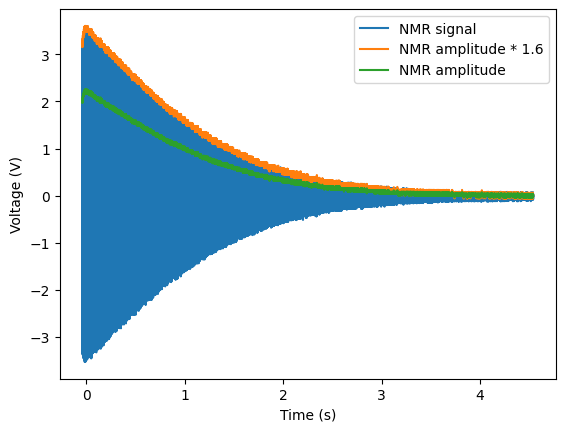

T2 = 1.220s


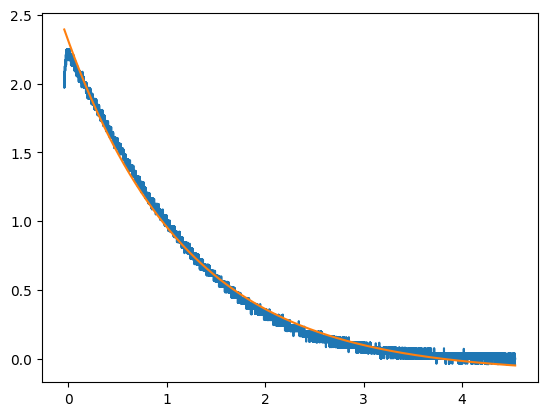

In [55]:
class NMR_data:
    def __init__(self, filepath, cutoff_below=None):
        self.file = filepath
        df = pd.read_csv(filepath, skiprows=[1])
        df = df.replace([np.inf, -np.inf, np.nan], 0)

        if cutoff_below:
            start_index = df[df['4'] > cutoff_below].index[0]
            df_filtered = df.iloc[start_index:]
            df_filtered = df_filtered.reset_index(drop=True)
            self.df = df_filtered
        else:
            self.df = df

        self.time = self.df["x-axis"]
        self.signal = self.df["2"]
        self.amplitude = self.df["4"]

data1 = NMR_data(r"C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\raw osc data\nmr-pt4-cv29.91v.csv", cutoff_below=2)
plt.plot(data1.time, data1.signal, label='NMR signal')
plt.plot(data1.time, data1.amplitude*1.6, label='NMR amplitude * 1.6')
plt.plot(data1.time, data1.amplitude, label='NMR amplitude')

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()

# Show the plot
plt.show()



def t2_function(t, A, B, T2):
    return A * np.exp(-t/T2) + B

popt, pcov = curve_fit(t2_function, data1.time, data1.amplitude, p0=[3.5, 0, 1])

plt.plot(data1.time, data1.amplitude, label='NMR amplitude')
plt.plot(data1.time, t2_function(data1.time, *popt), label='Fitted function')

print(f"T2 = {popt[2]:.3f}s")